In [1]:
pip install --upgrade google-cloud-bigquery

     |████████████████████████████████| 163kB 3.0MB/s 
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0
  Found existing installation: google-cloud-bigquery 1.21.0
    Uninstalling google-cloud-bigquery-1.21.0:
      Successfully uninstalled google-cloud-bigquery-1.21.0


In [2]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'capstone-247602'
client = bigquery.Client(project=project_id)

for dataset in client.list_datasets():
  print(dataset.dataset_id)

import pandas as pd

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'capstone-247602'
df_full = pd.io.gbq.read_gbq('''
SELECT * FROM `capstone-247602.combined_digital_linear.tbl_title_matching_stage_3_FINAL`''', 
project_id=project_id, verbose=False)


Digital_Data
Nielsen_Data
combined_digital_linear
predictions


/usr/local/lib/python3.6/dist-packages/pandas/io/gbq.py:176: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs


In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# Filter main dataframe by SHOW
# Add in calculated features
# Make airdate the index
# create dataframe of features for Average Mins Viewed and Imps

import warnings
warnings.filterwarnings("ignore")

show_name = "SUPERSTORE"
show_table = df_full[df_full.Show_Name == show_name]

show_table['days_since_last_episode'] = show_table.groupby('Season')['airdate'].diff().fillna(0).astype(str).str[:2]
show_table['days_since_1st_episode'] = (show_table.airdate - show_table.airdate.min()).astype(str).str[:2]

show_table['airdate']= pd.to_datetime(show_table['airdate']) 
show_table = show_table.set_index('airdate')


df_amv = show_table[[ 'average_mins_viewed']]

df_I = show_table[[ 'Imps']]

forecast_cols = ['average_mins_viewed', 'Imps']
dfs = [df_amv,df_I]

print(len(df_amv),len(df_I))
df_amv.head()

69 69


,average_mins_viewed
airdate,
2015-11-30,1.413085e+06
2016-01-04,1.902009e+06
2016-01-11,1.842468e+06
2016-01-18,1.825329e+06
2016-01-25,1.845576e+06


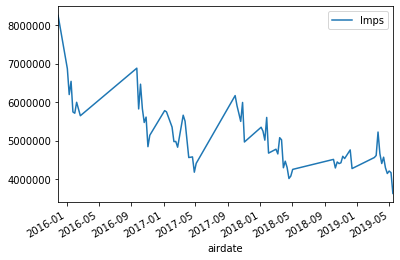

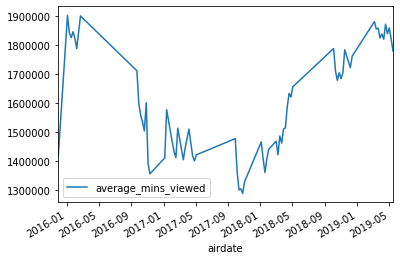

In [18]:
df_I.plot()
df_amv.plot()
plt.show()

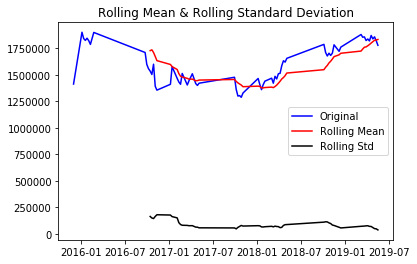

In [92]:
df=df_amv
fieldname='average_mins_viewed'
# Testing for Stationality
# Rolling mean and std should be flat
# https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [93]:
result = adfuller(df[fieldname])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

    '''The ADF Statistic is far from the critical values and the p-value is greater than the threshold (0.05). 
    Thus, we can conclude that the time series is not stationary.'''

ADF Statistic: -2.1906581163475223
p-value: 0.20965347631425668
Critical Values:
	1%: -3.540522678829176
	5%: -2.9094272025108254
	10%: -2.5923136524453696


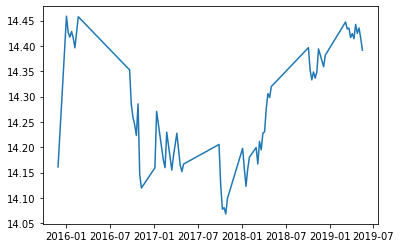

In [94]:
df_log = np.log(df)
plt.plot(df_log)

In [0]:
def get_stationarity(timeseries, fieldname):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries[fieldname])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

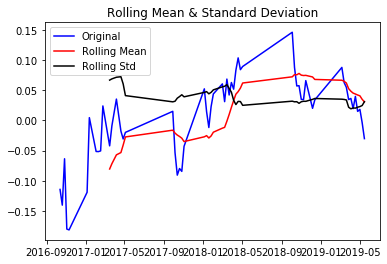

ADF Statistic: -2.7507518164074263
p-value: 0.06566013267532245
Critical Values:
	1%: -3.5506699942762414
	5%: -2.913766394626147
	10%: -2.5946240473991997


In [96]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean, fieldname)

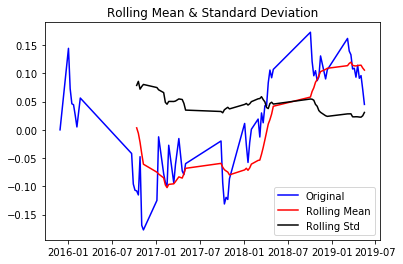

ADF Statistic: -1.5895534635957724
p-value: 0.4888390179605675
Critical Values:
	1%: -3.540522678829176
	5%: -2.9094272025108254
	10%: -2.5923136524453696


In [97]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay, fieldname)

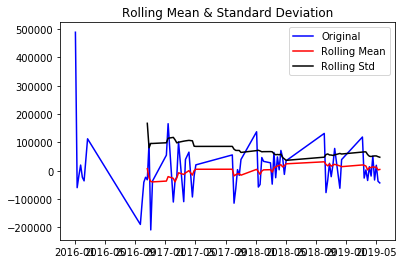

ADF Statistic: -2.2902428499090437
p-value: 0.1751341597206908
Critical Values:
	1%: -3.540522678829176
	5%: -2.9094272025108254
	10%: -2.5923136524453696


In [98]:
df_shift = df - df.shift()
df_shift.dropna(inplace=True)
get_stationarity(df_shift, fieldname)

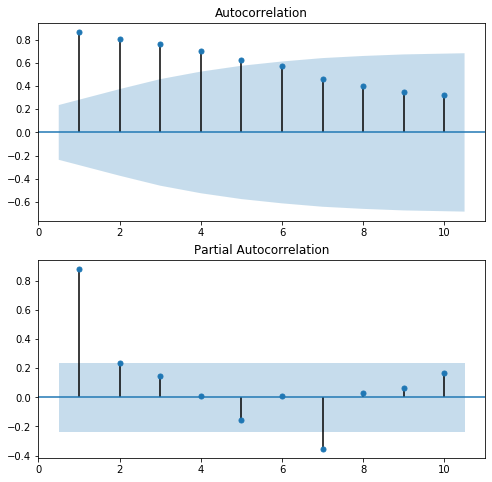

In [102]:
# ACF and PACF to determine model order
# data must be made sationary 1st
# AR(p) - ACF tails off & PACF cuts off after lag p
# MA(q) - ACF cuts off after lag q & PACF tails off
# ARMA(p,q) - ACF tails off & PACF tails off

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

plot_acf(df, lags=10, zero=False, ax=ax1)

plot_pacf(df, lags=10, zero=False, ax=ax2)

plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


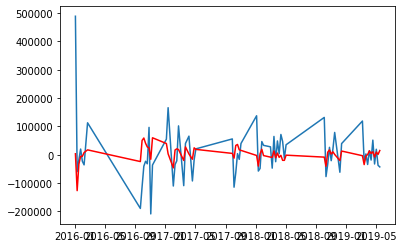

In [99]:
decomposition = seasonal_decompose(df, freq=52) 
model = ARIMA(df, order=(1,1,1))
results = model.fit(disp=-1)
plt.plot(df_shift)
plt.plot(results.fittedvalues, color='red')

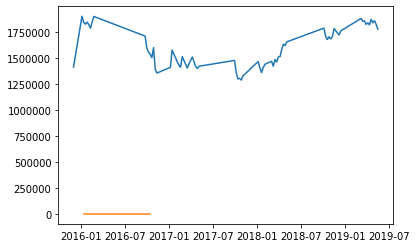

In [100]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log[fieldname].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


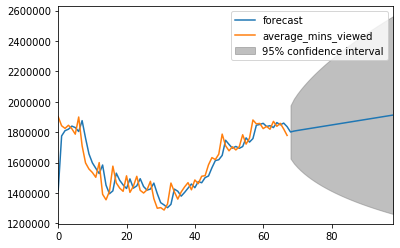

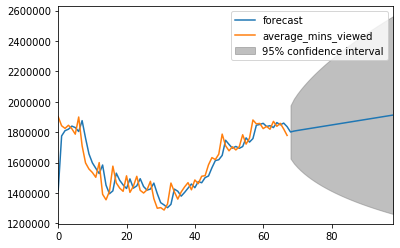

In [101]:
results.plot_predict(1,len(df)+30)

In [108]:
# ARIMA Model import
from statsmodels.tsa.statespace.sarimax import SARIMAX
# model diagnostics

residuals = results.resid

mae = np.mean(np.abs(residuals))

print(mae)

#results.plot_diagnostics()
plt.show()

print(results.summary())
# prob(Q) - p-value for null hyp that residual are uncorrelated - value under 0.05 they are correlated.
# prob(JB) - p-vlaue for null hyp that residuals are normal - value under 0.05 they are not normally distributed.
# if either is less then 0.05 we reject the null hyp

60773.2741002223
                               ARIMA Model Results                               
Dep. Variable:     D.average_mins_viewed   No. Observations:                   68
Model:                    ARIMA(1, 1, 1)   Log Likelihood                -871.672
Method:                          css-mle   S.D. of innovations          89229.462
Date:                   Fri, 17 Jan 2020   AIC                           1751.344
Time:                           14:11:59   BIC                           1760.222
Sample:                                1   HQIC                          1754.862
                                                                                 
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        3622.7985   7178.405      0.505      0.615   -1.04e+04    1.77e+04
ar.L1.D.average_mins_viewed     0.1227 